In [76]:
!pip install pip install azure-ai-ml azure-identity
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Model
from azure.identity import DefaultAzureCredential

subscription_id = "5ddf05c0-b972-44ca-b90a-3e49b5de80dd"
resource_group = "cvbia_test"
workspace = "test-knvb-ml"

ml_client = MLClient(DefaultAzureCredential(), subscription_id, resource_group, workspace)

You should consider upgrading via the '/Users/virginia/.pyenv/versions/3.10/envs/thor_310/bin/python3 -m pip install --upgrade pip' command.


In [77]:
import pandas as pd

white_wine = pd.read_csv("winequality-white.csv", sep=";")
red_wine = pd.read_csv("winequality-red.csv", sep=",")



In [78]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [79]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [80]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

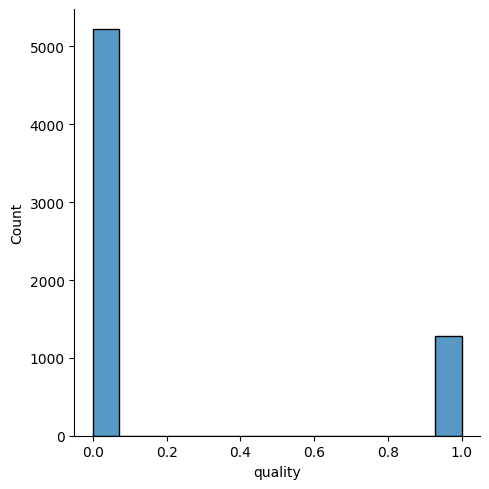

In [81]:
import seaborn as sns
sns.displot(data.quality, kde=False)

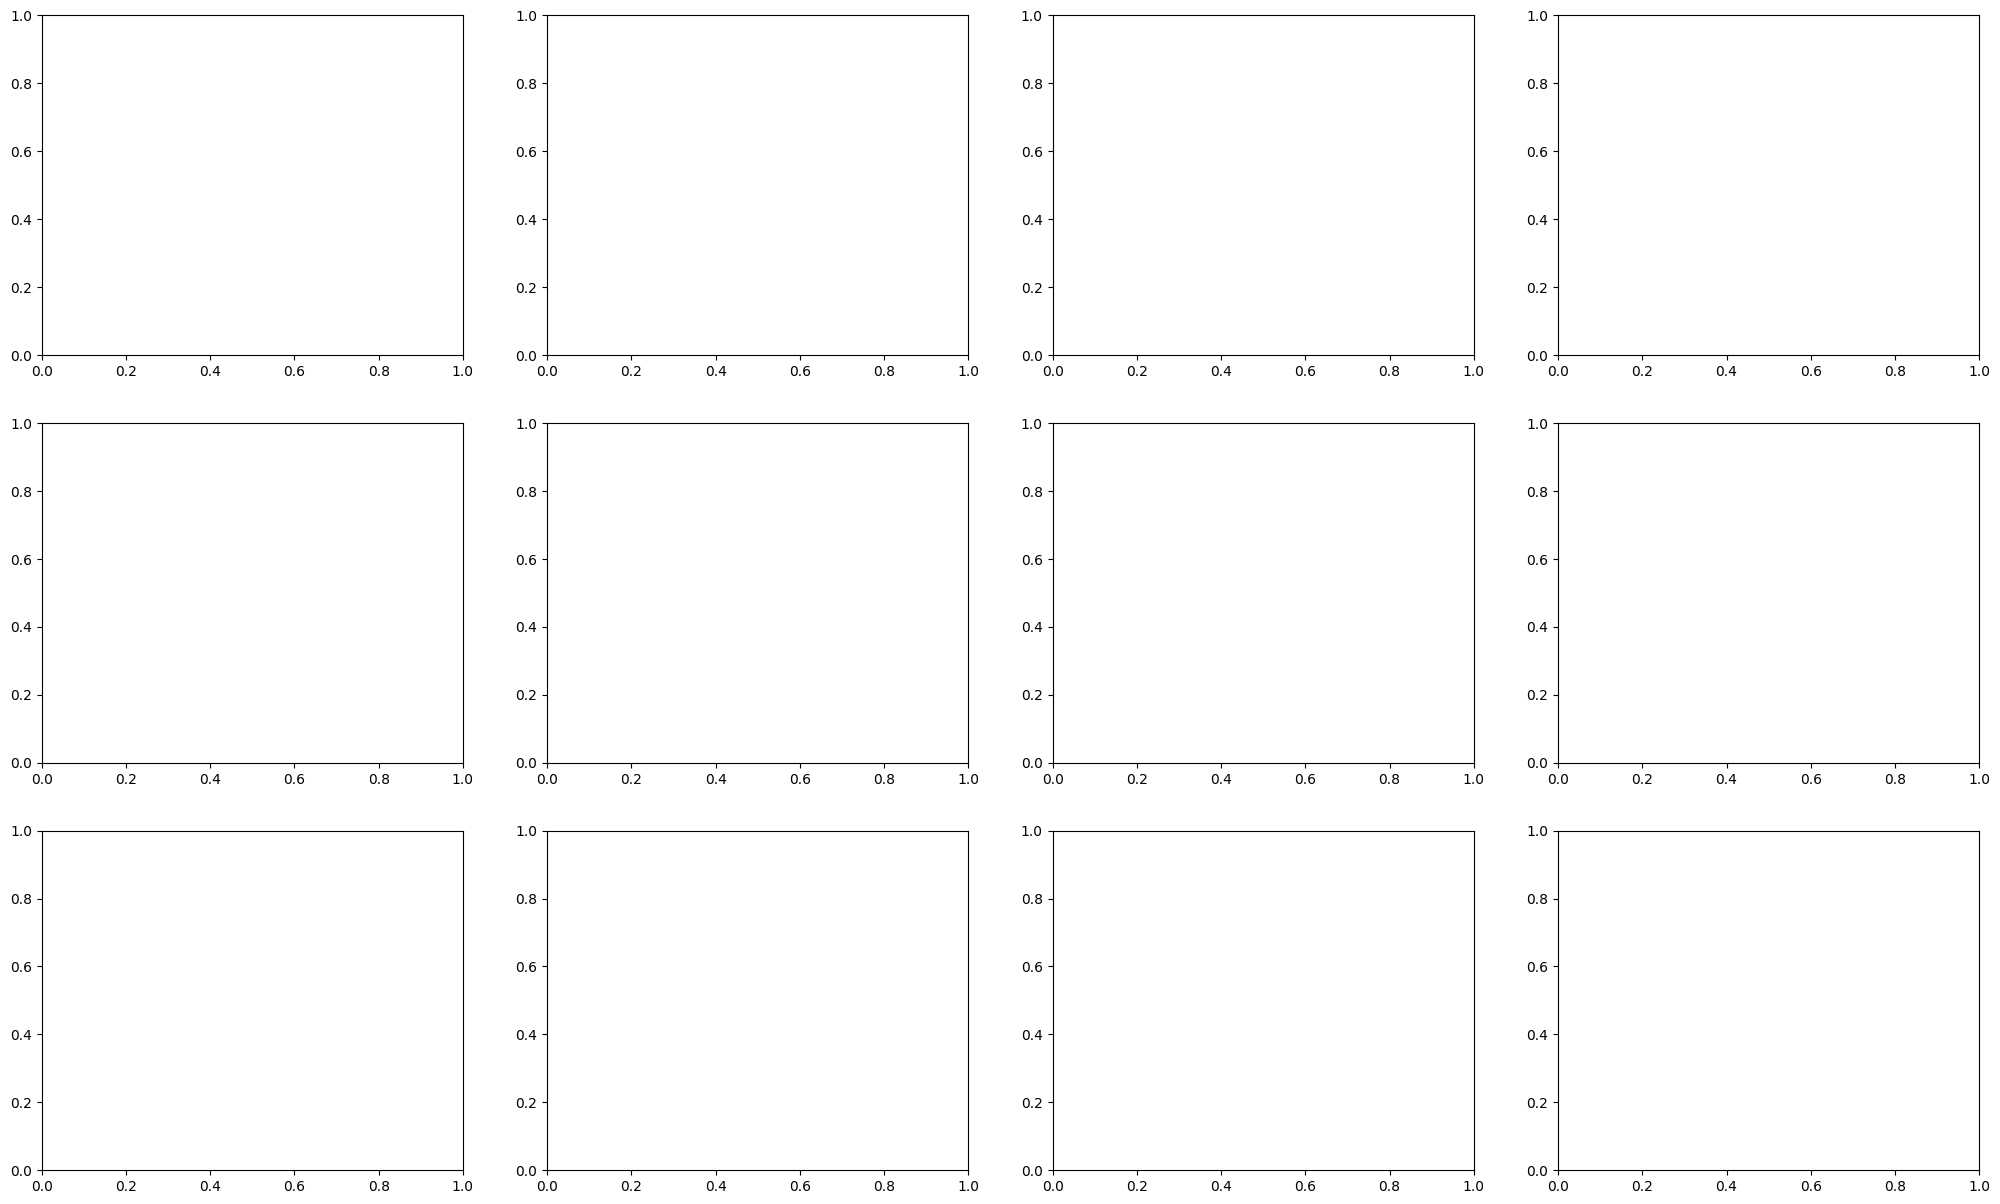

In [82]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables


In [20]:
!pip install mlflow seaborn scikit-learn

     |████████████████████████████████| 294 kB 2.6 MB/s eta 0:00:01
You should consider upgrading via the '/Users/virginia/.pyenv/versions/3.10/envs/thor_310/bin/python3 -m pip install --upgrade pip' command.


In [83]:
from sklearn.model_selection import train_test_split

X = data.drop(["quality"], axis=1)
y = data.quality

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

In [84]:
X_train.head()
print(X_train)
print(y_train)

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
543             6.7              0.24         0.41            8.70      0.036   
4540            5.8              0.28         0.30            3.90      0.026   
1429            6.1              0.22         0.49            1.50      0.051   
2092            5.3              0.76         0.03            2.70      0.043   
1255            6.1              0.64         0.02            2.40      0.069   
...             ...               ...          ...             ...        ...   
3619            6.8              0.45         0.28           26.05      0.031   
2461            8.2              0.26         0.33            2.60      0.053   
1346            6.1              0.59         0.01            2.10      0.056   
1855            8.0              0.22         0.28           14.00      0.053   
1983            7.6              0.20         0.30           14.20      0.056   

      free_sulfur_dioxide  

In [85]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)
  print(model, X_test)
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

RandomForestClassifier(n_estimators=10,
                       random_state=RandomState(MT19937) at 0x17E0A0840)       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
1268            7.6              0.31         0.29            10.5      0.040   
2085            7.9              0.17         0.32             1.6      0.053   
990             8.6              0.16         0.38             3.4      0.040   
3910            7.1              0.37         0.30             6.2      0.040   
163             7.4              0.24         0.42            14.0      0.066   
...             ...               ...          ...             ...        ...   
1565            8.5              0.19         0.49             3.5      0.044   
249             6.1              0.41         0.14            10.4      0.037   
1063           10.2              0.29         0.65             2.4      0.075   
831             5.9              0.61         0.08             2.1      0.071

/Users/virginia/.pyenv/versions/3.10/envs/thor_310/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/virginia/.pyenv/versions/3.10/envs/thor_310/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces th

In [86]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id
run_id

'3723d7b7d6794e6ba095eceebdc5fab6'

In [87]:
model_name = "wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'wine_quality' already exists. Creating a new version of this model...
Created version '2' of model 'wine_quality'.


In [88]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

/var/folders/q0/hzvldg5j5vv_b6qpkbyrd8y80000gp/T/ipykernel_24692/3087969861.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1721128273820, current_stage='Production', description=None, last_updated_timestamp=1721128297833, name='wine_quality', run_id='3723d7b7d6794e6ba095eceebdc5fab6', run_link=None, source='file:///Users/virginia/Documents/workspace/test_knvb/mlruns/0/3723d7b7d6794e6ba095eceebdc5fab6/artifacts/random_forest_model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [89]:
file_model = Model(
    path="mlruns/0/284424a3c6914445b4793f834c243319/artifacts/random_forest_model/python_model.pkl",
    name="local-file-example",
    description="Model created from local file.",
)
ml_client.models.create_or_update(file_model)

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

/var/folders/q0/hzvldg5j5vv_b6qpkbyrd8y80000gp/T/ipykernel_24692/3849290384.py:9: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1721128273820, current_stage='Production', description=None, last_updated_timestamp=1721128317866, name='wine_quality', run_id='3723d7b7d6794e6ba095eceebdc5fab6', run_link=None, source='file:///Users/virginia/Documents/workspace/test_knvb/mlruns/0/3723d7b7d6794e6ba095eceebdc5fab6/artifacts/random_forest_model', status='READY', status_message=None, tags={}, user_id=None, version=2>